In [1]:
import re
import matplotlib as mpl

import glob
import os
import shutil
import traceback
import json
import cv2
import h5py

import math
import skimage
import time


import numpy as np
import pylab as pl
import seaborn as sns
import pandas as pd
import tifffile as tf
import cPickle as pkl
import matplotlib.colors as mcolors
import sklearn.metrics as skmetrics 
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pipeline.python import utils as putils
from pipeline.python.retinotopy import utils as ret_utils
from pipeline.python.rois import utils as roi_utils
from pipeline.python.coregistration import align_fov as coreg
from pipeline.python.classifications import gradient_estimation as grd
from pipeline.python.classifications import aggregate_data_stats as aggr

from scipy import misc,interpolate,stats,signal
from matplotlib.colors import LinearSegmentedColormap


from skimage.color import label2rgb
#from skimage.measure import label, regionprops, find_contours
import skimage.measure as skmeasure
from skimage.measure import block_reduce


/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/retinotopy/utils.py:10: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/traces/get_traces.py:96: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 65

/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/2p-pipeline/pipeline/python/paradigm/tifs_to_data_arrays.py:9: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/n/coxfs01/2p-pipeline/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py

In [3]:
%matplotlib inline

## Some aggregate plotting stuff

In [4]:
visual_areas, area_colors = putils.set_threecolor_palette()
dpi = putils.set_plot_params(lw_axes=2)

# Select colormap

('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'azimuth_pos_nic_Edge_LEGEND_abs')
('/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy', 'elevation_pos_nic_Edge_LEGEND_abs')


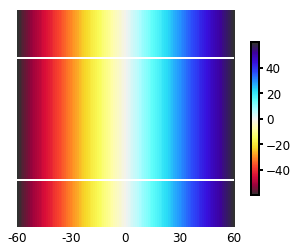

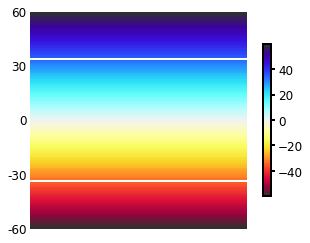

In [5]:
# # Load colormap
cmap_name = 'nic_Edge'
# zero_center = True
screen, cmap_phase = ret_utils.get_retino_legends(cmap_name=cmap_name, zero_center=True, 
                                                   return_cmap=True)

# Set output dirs

In [6]:
rootdir = '/n/coxfs01/2p-data'
aggr_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'

aggr_retino_dir = os.path.join(aggr_dir, 'retinotopy') #, 'figures', 'caiman-examples')
if not os.path.exists(aggr_retino_dir):
    os.makedirs(aggr_retino_dir)
aggr_retino_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/retinotopy'

# Metadata

In [7]:
# Get all data sets
traceid='traces001'

sdata = aggr.get_aggregate_info(traceid=traceid) #, fov_type=fov_type, state=state)
retinodata = sdata[sdata['experiment']=='retino'].copy()
retinodata.groupby(['visual_area']).count()

,animalid,experiment,fov,session,fovnum,datakey
visual_area,,,,,,
Li,23,23,23,23,23,23
Lm,19,19,19,19,19,19
V1,15,15,15,15,15,15


In [8]:
# screen info
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max

# Do one at a time

In [9]:
curr_visual_area='Li'
retinodata[retinodata['visual_area']==curr_visual_area].sort_values(by=['animalid', 'session'])

,animalid,experiment,fov,session,visual_area,fovnum,datakey
133,JC076,retino,FOV1_zoom2p0x,20190422,Li,1,20190422_JC076_fov1
156,JC080,retino,FOV1_zoom2p0x,20190602,Li,1,20190602_JC080_fov1
44,JC089,retino,FOV1_zoom2p0x,20190522,Li,1,20190522_JC089_fov1
55,JC090,retino,FOV1_zoom2p0x,20190605,Li,1,20190605_JC090_fov1
36,JC091,retino,FOV1_zoom2p0x,20190602,Li,1,20190602_JC091_fov1
31,JC091,retino,FOV1_zoom2p0x,20190606,Li,1,20190606_JC091_fov1
23,JC091,retino,FOV1_zoom2p0x,20190607,Li,1,20190607_JC091_fov1
27,JC091,retino,FOV1_zoom2p0x,20190614,Li,1,20190614_JC091_fov1
17,JC091,retino,FOV1_zoom2p0x,20191008,Li,1,20191008_JC091_fov1
47,JC092,retino,FOV3_zoom2p0x,20190527,Li,3,20190527_JC092_fov3


# Example FOV ----------------------------------------------------------------------

In [11]:
from pipeline.python.retinotopy import segment_retinotopy as seg
import scipy.stats as spstats
from pipeline.python.classifications import evaluate_receptivefield_fits as evalrf

In [60]:
datakey = '20190614_JC091_fov1'
session, animalid, fovn = datakey.split('_')
fovnum = int(fovn[3:])

# animalid = 'JC092'
# session = '20190528'
# fovnum = 1

fov = 'FOV%i_zoom2p0x' % fovnum
traceid = 'traces001'

#datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# Get retino runs
found_retinoruns = [os.path.split(d)[-1] for d in 
                    glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))]
print("Found %i runs" % len(found_retinoruns))
retinorun = found_retinoruns[0]


data_id = '_'.join([animalid, session, fov, retinorun])

Found 1 runs


In [55]:
screen = putils.get_screen_dims()
screen_max = screen['azimuth_deg']/2.
screen_min = -screen_max
vmin, vmax = (screen_min, screen_max)

In [15]:
## Load segmentation
results, params = seg.load_segmentation_results(animalid, session, fov, retinorun=retinorun)

In [111]:
## Get inputmaps
if 'morphological_kernels' not in params.keys():
    pixel_size = putils.get_pixel_size()
    target_sigm_um = round(np.ceil(params['smooth_fwhm'] * np.mean(pixel_size)))
    use_phase_smooth = params['smooth_type']=='phasenan'

try:
    img_az, img_el, pparams = seg.load_final_maps(animalid, session, fov, retinorun=retinorun, return_screen=True)
except Exception as e:
    az_fill, el_fill, pparams = seg.smooth_processed_maps(animalid, session, fov, retinorun=retinorun,
                                                    target_sigma_um=target_sigm_um,
                                                    start_with_transformed=params['start_with_transformed'],
                                                    smooth_spline=params['smooth_spline'],
                                                    use_phase_smooth=use_phase_smooth, cmap_phase=cmap_phase,
                                                    reprocess=True)

img_az, img_el, pparams = seg.load_final_maps(animalid, session, fov, retinorun=retinorun, return_screen=True)



19.0

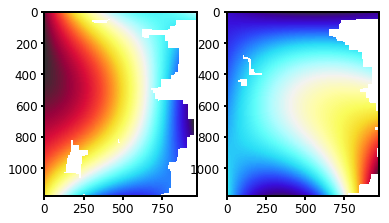

In [42]:
# Check 

f, axn = pl.subplots(1,2)
axn[0].imshow(img_az, cmap=cmap_phase)
axn[1].imshow(img_el, cmap=cmap_phase)

# Get gradients and projections

In [43]:
segmented_areas = results['areas']
print(segmented_areas.keys())

[1, 2, 4, 5, 'Li']


In [44]:
curr_visual_area='Li'
area_results = segmented_areas[curr_visual_area]
curr_segmented_mask = area_results['mask']


In [46]:
# Get gradients and plot
grad_az, grad_el = seg.calculate_gradients(curr_segmented_mask, img_az, img_el)

Text(0.5,0.98,u'Li')

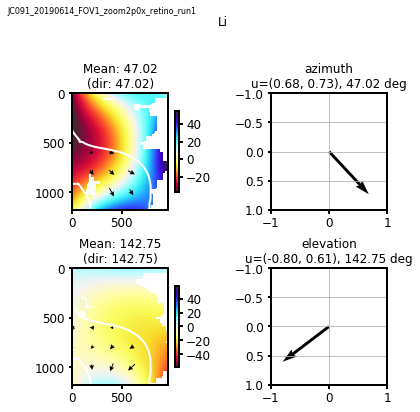

In [61]:
labeled_image = results['labeled_image'].copy()

curr_labeled_image = np.zeros(labeled_image.shape)
curr_labeled_image[labeled_image==area_results['id']] = 1
fig = seg.plot_gradients_in_area(curr_labeled_image, img_az, img_el, grad_az, grad_el,
                            cmap_phase=cmap_phase,
                            contour_lc='w', contour_lw=2)
pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)
putils.label_figure(fig, data_id)
fig.suptitle(curr_visual_area)

## Calculate projections

In [112]:
projections = grd.get_projection_points(grad_az, grad_el)

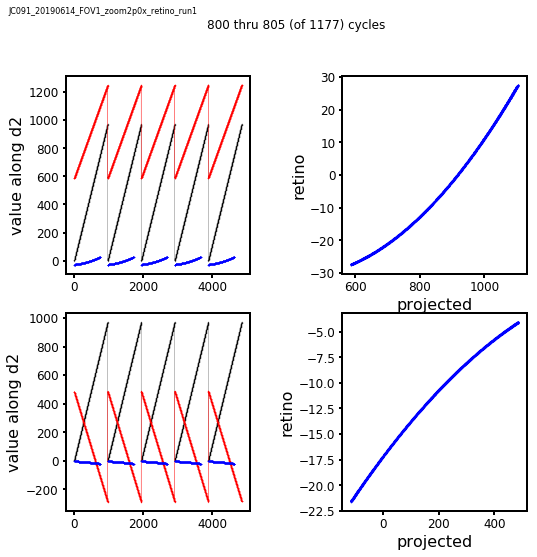

In [113]:
d1, d2 = grad_az['image'].shape
fig = grd.test_plot_projections(projections, ncyc=5, startcyc=800, imshape=(d1,d2))
putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'test_projections'



## Get projected points

In [115]:
regr_model='ridge'
mag_thr = params['pixel_mag_thr']
pass_criterion = 'na'

#%% ## Fit linear
proj_fit_results = {}
d_list = []
di = 0
for i, cond in enumerate(['az', 'el']):
    proj_v = projections['proj_%s' % cond].copy()
    ret_v = projections['retino_%s' % cond].copy()
    fitv, regr = evalrf.fit_linear_regr(proj_v[~np.isnan(ret_v)],
                                        ret_v[~np.isnan(ret_v)],
                                        return_regr=True, model=regr_model)

    rmse = np.sqrt(skmetrics.mean_squared_error(ret_v[~np.isnan(ret_v)], fitv))
    r2 = skmetrics.r2_score(ret_v[~np.isnan(ret_v)], fitv)
    pearson_r, pearson_p = spstats.pearsonr(proj_v[~np.isnan(ret_v)], ret_v[~np.isnan(ret_v)])
    slope = float(regr.coef_)
    intercept = float(regr.intercept_)

    proj_fit_results.update({'fitv_%s' % cond: fitv, 'regr_%s' % cond: regr})

    d_ = pd.DataFrame({'cond': cond,
                      'R2': r2,
                      'RMSE': rmse,
                      'pearson_p': pearson_p,
                      'pearson_r': pearson_r,
                      'coefficient': slope,
                      'intercept': intercept}, index=[di])
    print("~~~regr results: y = %.2f + %.2f (R2=%.2f)" % (slope, intercept, r2))
    d_list.append(d_)
    di += 1
regr_df = pd.concat(d_list, axis=0)

proj_fit_results.update({'projections': projections,
                         'model': regr_model,
                         'mag_thr': mag_thr,
                         'pass_criterion': pass_criterion,
                         'regr_df': regr_df})

~~~regr results: y = 0.09 + -81.62 (R2=0.96)
~~~regr results: y = 0.04 + -16.56 (R2=0.81)


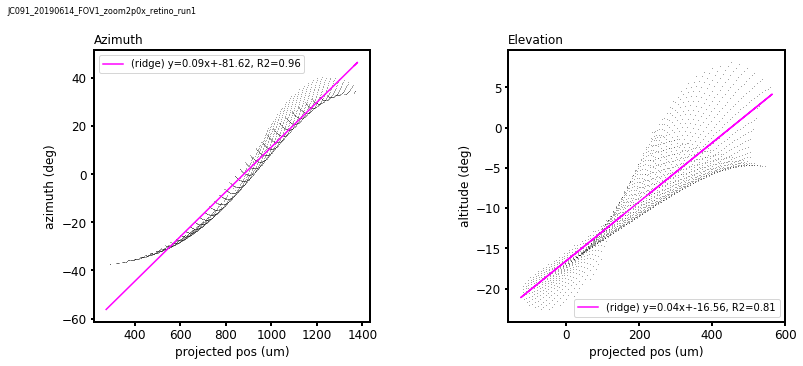

In [77]:
regr_plot_spacing=200
regr_line_color='magenta'

#%% Plot linear fit
fig = grd.plot_projected_vs_retino_positions(projections, proj_fit_results,
                                         spacing=regr_plot_spacing,
                                         regr_color=regr_line_color)
putils.label_figure(fig, data_id)
pl.subplots_adjust(left=0.1, wspace=0.5)
figname = 'Proj_versus_Retinopos__'
#pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))


## Run step by step

In [88]:
# Load data metainfo
print("Current run: %s" % retinorun)
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Load MW info and SI info
mwinfo = ret_utils.load_mw_info(animalid, session, fov, retinorun)
scaninfo = ret_utils.get_protocol_info(animalid, session, fov, run=retinorun) 
trials_by_cond = scaninfo['trials']

# Set current animal's retino output dir
run_dir = RETID['DST'].split('/retino_analysis/')[0]
curr_dst_dir = os.path.join(run_dir, 'retino_analysis', 'segmentation')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
    print("Saving output to:\n %s" % curr_dst_dir)
    
# Get run results
magratio, phase, trials_by_cond = ret_utils.fft_results_by_trial(RETID)

d2 = scaninfo['pixels_per_line']
d1 = scaninfo['lines_per_frame']
print("Original dims: [%i, %i]" % (d1, d2))

# Get ROIID and projection image
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

# Get pixel size
pixel_size = putils.get_pixel_size()
pixel_size_ds = (pixel_size[0]*ds_factor, pixel_size[1]*ds_factor)


Current run: retino_run1
FOV: FOV1_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC117_20191104_FOV1_zoom2p0x_retino_run1_analysis001
Trials by cond:
{u'blank': [11, 12, 16, 19], u'top': [10, 18, 1, 4], u'right': [13, 17, 3, 6], u'bottom': [15, 14, 20, 7], u'left': [2, 5, 9, 8]}
Original dims: [512, 512]
Data were downsampled by 2.


('got phase:', 0.0007934409114143115, 6.283180606001123)
('got absolute:', -2.930565293489258, 3.0329499967123796)
('Delay:', 0.2326892476799194, 6.144684692197984)


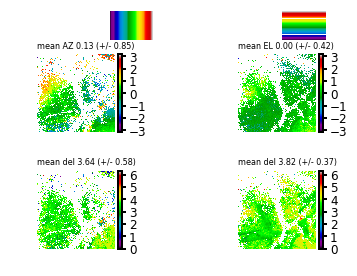

In [89]:
pix_mag_thr=0.002

abs_vmin, abs_vmax = (-np.pi, np.pi)
absolute_az, absolute_el, delay_az, delay_el = ret_utils.absolute_maps_from_conds(magratio, phase, trials_by_cond,
                                                                                 mag_thr=pix_mag_thr, dims=(d1, d2),
                                                                                 plot_conditions=False, ds_factor=ds_factor)

# shift_az_delay = ret_utils.convert_values(delay_az, newmin=-np.pi, newmax=np.pi, 
#                                           oldmin=0, oldmax=2*np.pi)
# shift_el_delay = ret_utils.convert_values(delay_el, newmin=-np.pi, newmax=np.pi, 
#                                           oldmin=0, oldmax=2*np.pi)

fig = ret_utils.plot_phase_and_delay_maps(absolute_az, absolute_el, 
                                          delay_az, delay_el,
                                          cmap='nipy_spectral', vmin=abs_vmin, vmax=abs_vmax)


#### Filter where delay map is not uniform (Az v El)

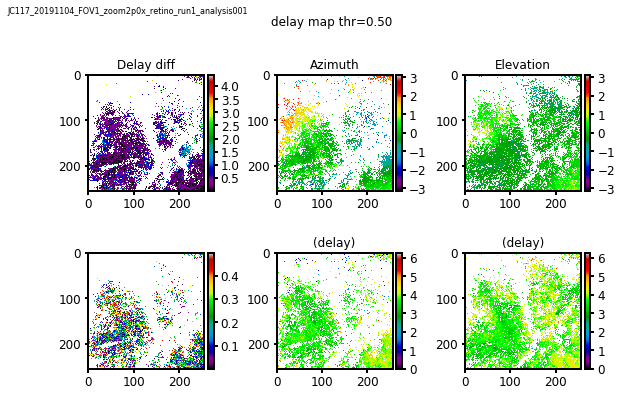

In [101]:
delay_map_thr=0.5

fig, filt_az, filt_el = ret_utils.filter_by_delay_map(absolute_az, absolute_el, delay_az, delay_el, 
                                                        delay_map_thr=delay_map_thr, plot=True)

filt_azim_r = coreg.transform_2p_fov(filt_az, pixel_size_ds, normalize=False)
filt_elev_r = coreg.transform_2p_fov(filt_el, pixel_size_ds, normalize=False)

putils.label_figure(fig, data_id)

pl.savefig(os.path.join(curr_dst_dir, 'delay_map_filters.png'))

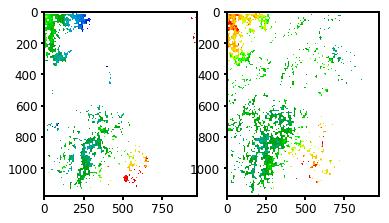

In [102]:
# Transform FOV to match widefield
f, axn = pl.subplots(1,2)
axn[0].imshow(filt_azim_r, cmap='nipy_spectral')
axn[1].imshow(filt_elev_r, cmap='nipy_spectral')



#### Smooth

Target: 25 (fwhm=12)
(u'/n/coxfs01/2p-data/JC117/20191104/FOV1_zoom2p0x/retino_run1/retino_analysis/segmentation', 'pixelmaps_smooth-12_magthr-0.002_delaymapthr-0.50')


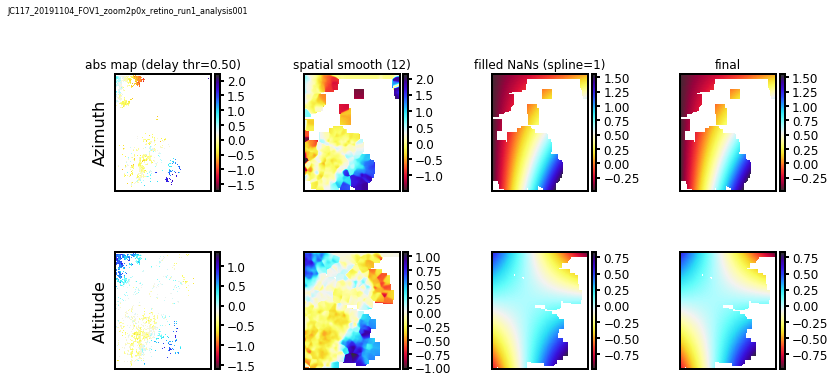

In [103]:
# Spatial smooth neuropil dilated masks 
smooth_spline=1 # Make larger if >1 area, use fill_and_smooth_nans_missing()
target_sigma_um=25 # # Marhsel et al 2014, make smaller if too much coverage? for some reson fill_and_smooth_nans_missing() fails if too covered

start_with_transformed=True
use_phase_smooth=False

um_per_pix = np.mean(pixel_size) if start_with_transformed else np.mean(pixel_size_ds)
smooth_fwhm = int(round(target_sigma_um/um_per_pix))  # int(25*pix_per_deg) #11
sz=smooth_fwhm*2 #smooth_fwhm
print("Target: %i (fwhm=%i)" % (target_sigma_um, smooth_fwhm)) #, sz)
smooth_type = 'phasenan'if use_phase_smooth else 'gaussian'

start_az = filt_azim_r.copy() if start_with_transformed else filt_az.copy()
start_el = filt_elev_r.copy() if start_with_transformed else filt_el.copy()

if use_phase_smooth:
    azim_smoothed = ret_utils.smooth_phase_nans(start_az, smooth_fwhm, sz)
    elev_smoothed = ret_utils.smooth_phase_nans(start_el, smooth_fwhm, sz)
else:
    azim_smoothed = ret_utils.smooth_neuropil(start_az, smooth_fwhm=smooth_fwhm)
    elev_smoothed = ret_utils.smooth_neuropil(start_el, smooth_fwhm=smooth_fwhm)

#azim_fillnan = grd.fill_and_smooth_nans(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
#elev_fillnan = grd.fill_and_smooth_nans(elev_smoothed, kx=smooth_spline, ky=smooth_spline)
if len(np.where(np.isnan(azim_smoothed))[0])>0:
    azim_fillnan = grd.fill_and_smooth_nans_missing(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
else:
    #azim_fillnan = azim_smoothed.copy()
    azim_fillnan = grd.fill_and_smooth_nans(azim_smoothed, kx=smooth_spline, ky=smooth_spline)
if len(np.where(np.isnan(elev_smoothed))[0])>2500:
    elev_fillnan = grd.fill_and_smooth_nans_missing(elev_smoothed, kx=smooth_spline, ky=smooth_spline)
else:
    #elev_fillnan = elev_smoothed.copy()
    elev_fillnan = grd.fill_and_smooth_nans(elev_smoothed, kx=smooth_spline, ky=smooth_spline)
# Transform FOV to match widefield
az_fill = coreg.transform_2p_fov(azim_fillnan, pixel_size, normalize=False) if not start_with_transformed else azim_fillnan
el_fill = coreg.transform_2p_fov(elev_fillnan, pixel_size, normalize=False) if not start_with_transformed else elev_fillnan

#az_fill = azim_r.copy()
#el_fill = elev_r.copy()
vmin, vmax = (-np.pi, np.pi)

fig = grd.plot_retinomap_processing_pixels(start_az, azim_smoothed, azim_fillnan, az_fill,
                                           start_el, elev_smoothed, elev_fillnan, el_fill,
                                         cmap_phase=cmap_phase, vmin=vmin, vmax=vmax, \
                                           smooth_fwhm=smooth_fwhm, smooth_spline=smooth_spline,
                                         delay_map_thr=delay_map_thr, full_cmap_range=False, show_cbar=True)

putils.label_figure(fig, data_id)
figname = 'pixelmaps_smooth-%i_magthr-%.3f_delaymapthr-%.2f' % (smooth_fwhm, pix_mag_thr, delay_map_thr)
pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
print(curr_dst_dir, figname)



# ----------------------------------
# MANUAL
# ----------------------------------

In [104]:
# curr_visual_area='Li'
# retinodata[retinodata['visual_area']==curr_visual_area].sort_values(by='animalid')

# Do it all in one go

In [105]:
# datakey = '20190605_JC090_fov1'
# session, animalid, fovn = datakey.split('_')
# fovnum = int(fovn[3:])


# fov = 'FOV%i_zoom2p0x' % fovnum
# traceid = 'traces001'

# datakey='%s_%s_fov%i' % (session, animalid, fovnum)

# # Get retino runs
# found_retinodirs = glob.glob(os.path.join(rootdir, animalid, session, fov, 'retino*'))
# found_retinoruns = [os.path.split(d)[-1] for d in found_retinodirs]
# print("Found %i runs" % len(found_retinoruns))

# # Set current animal's retino output dir
# run_ix = 0
# retinorun = found_retinoruns[run_ix]
# curr_dst_dir = os.path.join(found_retinodirs[run_ix], 'retino_analysis', 'segmentation')
# print(curr_dst_dir)

# data_id = '_'.join([animalid, session, fov, retinorun, traceid])


In [106]:
# delay_map_thr = 0.5
# pix_mag_thr = 0.002
# smooth_fwhm = 5
# smooth_spline=2
# cmap_name = 'nic_Edge'
# # ----------------------------------------------------------

# az_fill, el_fill, params, RETID = grd.pixel_gradients(animalid, session, fov, traceid=traceid, retinorun=retinorun, 
#                                                       mag_thr=pix_mag_thr, delay_map_thr=delay_map_thr, 
#                                                       dst_dir=curr_dst_dir, cmap=cmap_name, 
#                                                       smooth_fwhm=smooth_fwhm, smooth_spline=smooth_spline,
#                                                       full_cmap_range=False) 


## Get surface img

((512, 512), (1177, 972))


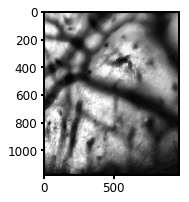

In [107]:
surface_img = ret_utils.load_2p_surface(animalid, session, fov, ch_num=1, retinorun=retinorun)
pixel_size = putils.get_pixel_size()
surface_2p = coreg.transform_2p_fov(surface_img, pixel_size, normalize=False)
surface_2p = putils.adjust_image_contrast(surface_2p, clip_limit=10.0, tile_size=5)
print(surface_img.shape, surface_2p.shape)

fig, ax = pl.subplots(figsize=(4,3))
ax.imshow(surface_2p, cmap='gray')

In [108]:
# if surface_img.shape[0] != absolute_az.shape[0]:
#     reduce_factor = surface_img.shape[0] / absolute_az.shape[0]
#     surface_img = block_reduce(surface_img, (2,2), func=np.mean)

# # transform to physical view
# surface_transf = coreg.orient_2p_to_macro(surface_img, zoom_factor=1., save=False, normalize=True)
# surface_r = coreg.scale_2p_fov(surface_transf, pixel_size=pixel_size)

# surface = putils.adjust_image_contrast(surface_r, clip_limit=2.0, tile_size=5)

# #print(surface_r.shape)
# f, ax = pl.subplots(figsize=(4,4))
# ax.imshow(surface)


# Convert to screen units

In [109]:
vmin=-np.pi
vmax=np.pi
img_az = putils.convert_range(az_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
img_el = putils.convert_range(el_fill, oldmin=vmin, oldmax=vmax, newmin=screen_min, newmax=screen_max)
vmin, vmax = (screen_min, screen_max)   
print(vmin, vmax)

(-59.7782, 59.7782)


# Identify borders using the gradients


# Segement areas

In [110]:
# Segmenting params
sign_map_thr = 0.1
min_region_area = 2000
# -------------------------------------------------------------------

O, S_thr = segment_areas(img_az, img_el, sign_map_thr=sign_map_thr, 
                         min_region_area=min_region_area, surface=surface_2p)

Text(0.5,1,u'dilation')

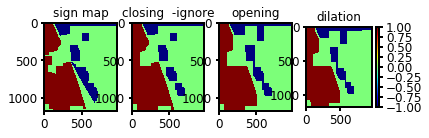

In [111]:
absolute_S_thr=False

#S=S_thr.copy() #np.sign(O) # Discretize into patches
S = abs(S_thr) if absolute_S_thr else S_thr.copy()
S[np.isnan(O)]=0

close_k = 91
niter = 1
kernel =  np.ones((close_k, close_k))
closing_s1 = cv2.morphologyEx(S, cv2.MORPH_CLOSE, kernel, iterations=niter)

dilate_k = 151
niter=1
kernel = np.ones((dilate_k, dilate_k))
opening_s1 = cv2.morphologyEx(closing_s1, cv2.MORPH_OPEN, kernel, iterations=niter)

k3 = 1 #close_k
niter = 1
kernel = np.ones((k3, k3))
dilation = cv2.dilate(opening_s1, kernel, iterations=niter)
# dilation = cv2.morphologyEx(opening_1, cv2.MORPH_CLOSE, kernel, iterations=niter)

#nozeros[S==0] = np.nan
#test_sm = grd.fill_nans(dilation)
f, axf = pl.subplots(1,4) #pl.figure()
axn = axf.flat
ax=axn[0]
ax.set_title("sign map")
ax.imshow(S,cmap='jet')

ax=axn[1]
im=ax.imshow(closing_s1, cmap='jet')
ax.set_title('closing  -ignore')

ax=axn[2]
im=ax.imshow(opening_s1, cmap='jet')
ax.set_title('opening')


ax=axn[3]
im=ax.imshow(dilation, cmap='jet')
putils.colorbar(im)
ax.set_title('dilation')

#### Test w/ morphological steps


#### Update segmentation params

In [77]:
seg_params = {'pixel_mag_thr': pix_mag_thr,
              'downsample_factor': ds_factor,
              'delay_map_thr': delay_map_thr,
              'smooth_fwhm': smooth_fwhm,
              'smooth_spline': smooth_spline,
              'smooth_type': smooth_type,
              'start_with_transformed': start_with_transformed,
              'dilate_k': dilate_k,
              'close_k': close_k,
              'absolute_S_thr': absolute_S_thr,
              'sign_map_thr': sign_map_thr,
              'min_region_area': min_region_area,
              'retino_id': retinoid, 
              'retino_run': retinorun}


In [78]:
# Label image
region_props, labeled_image  = segment_and_label(dilation)
region_labels = [region.label for region in region_props]
print('Found %i regions: %s' % (len(region_labels), str(region_labels)))

# Save
orig_d1, orig_d2 = surface_2p.shape
labeled_image_2p = cv2.resize(labeled_image.astype(np.uint8), (orig_d2, orig_d1)) #surface_2p.shape)
results = {'labeled_image_ds': labeled_image, 
           'labeled_image': labeled_image_2p,
           'region_props': region_props}


((1177, 972), (1177, 972, 3))
Found 1 regions: [1]


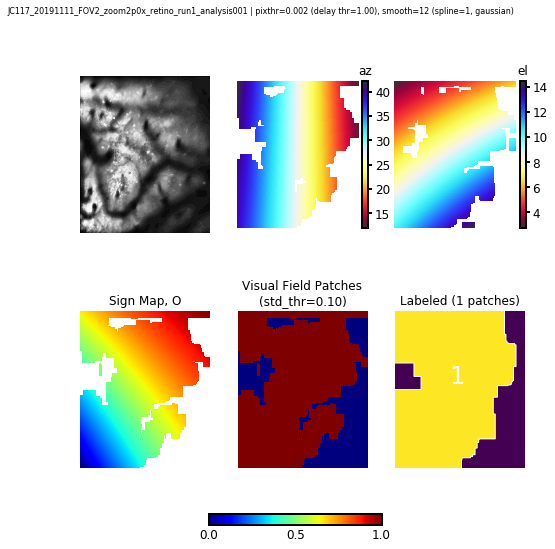

In [79]:
# Plot segmentation results
proc_info_str = 'pixthr=%.3f (delay thr=%.2f), smooth=%i (spline=%i, %s)' % (pix_mag_thr, delay_map_thr, smooth_fwhm, smooth_spline, smooth_type)
fig = plot_segmentation_steps(img_az, img_el, surface=surface_2p, O=O, S_thr=S_thr, params=seg_params, 
                               cmap=cmap_phase, labeled_image=labeled_image, region_props=region_props, label_color='w')

putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.subplots_adjust(hspace=0.5, bottom=0.2)
    
pl.savefig(os.path.join(curr_dst_dir, 'segemented_areas.png'))

# Select areas and label

('Lm', 873788)


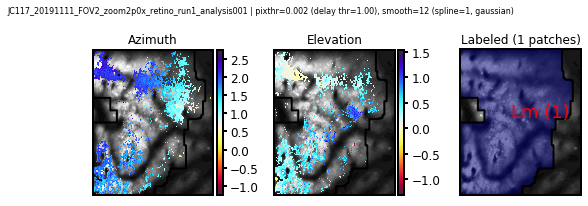

In [80]:
region_dict={1: 'Lm'} #,5:'Lm'} #, 2: 'AL', 4: 'Li'} #V1'}

seg_areas = {}
for ri, region in enumerate(region_props):
    region_id = region.label
    if region.label in region_dict.keys():
        region_name = region_dict[region.label]
        #label_keys.append((region_name, region_id))
    else:
        region_name = region.label

    # save mask
    region_mask = np.copy(labeled_image.astype('float'))
    region_mask[labeled_image != region_id] = 0
    region_mask[labeled_image == region_id] = 1
    if region_name in seg_areas.keys():
        region_mask = seg_areas[region_name]['mask'] + region_mask # Update region mask
        region_id = seg_areas[region_name]['id']
        labeled_image[region_mask==1] = seg_areas[region_name]['id'] # Update labeled image
    seg_areas[region_name] = {'id': region_id, 'mask': region_mask}

label_keys = [(k, v['id']) for k, v in seg_areas.items() if not(putils.isnumber(k))]

# double check labeling/naming of segmented areas
pos_multiplier = (1,1) if start_with_transformed else (pixel_size[0], pixel_size[1]) 
area_ids = [k[1] for k in label_keys]
labeled_image_incl = np.ones(labeled_image.shape)*np.nan #labeled_image.copy()
for idx in area_ids:
    labeled_image_incl[labeled_image==idx] = idx

# Transform FOV to match widefield
fig, axn = pl.subplots(1,3, figsize=(9,3))
ax=axn[0]
ax.imshow(surface_2p, cmap='gray')
ax.set_title('Azimuth')
im0 = ax.imshow(filt_azim_r, cmap=cmap_phase)
putils.colorbar(im0)
ax = overlay_all_contours(labeled_image_2p, ax=ax, lw=2, lc='k')
putils.turn_off_axis_ticks(ax, despine=False)

ax=axn[1]
ax.imshow(surface_2p, cmap='gray')
im1=ax.imshow(filt_elev_r, cmap=cmap_phase)
putils.colorbar(im1)
ax.set_title('Elevation')
ax = overlay_all_contours(labeled_image_2p, ax=ax, lw=2, lc='k')
putils.turn_off_axis_ticks(ax, despine=False)

ax=axn[2]
ax.imshow(surface_2p, cmap='gray')
labeled_image_incl_2p = cv2.resize(labeled_image_incl, (surface_2p.shape[1], surface_2p.shape[0]))
ax.imshow(labeled_image_incl_2p, cmap='jet', alpha=0.5)
ax = overlay_all_contours(labeled_image_2p, ax=ax, lw=2, lc='k')

for region in region_props:
    if region.label in area_ids:
        region_name = str([k[0] for k in label_keys if k[1]==region.label][0])
        ax.text(region.centroid[1]*pos_multiplier[0], region.centroid[0]*pos_multiplier[1], 
                        '%s (%i)' % (region_name, region.label), fontsize=18, color='r')
        print(region_name, region.area)
ax.set_title('Labeled (%i patches)' % len(area_ids))
putils.turn_off_axis_ticks(ax, despine=False)

putils.label_figure(fig, '%s | %s' % (data_id, proc_info_str))
pl.savefig(os.path.join(curr_dst_dir, 'labeled_areas.png'))

pl.subplots_adjust(wspace=0.3, top=0.8)

## Save results

In [81]:
# Load data metainfo
print("Current run: %s" % retinorun)
retinoid, RETID = ret_utils.load_retino_analysis_info(animalid, session, fov, retinorun, traceid, use_pixels=True)
data_id = '_'.join([animalid, session, fov, retinorun, retinoid])
print("DATA ID: %s" % data_id)

# Get ROIID and projection image
ds_factor = int(RETID['PARAMS']['downsample_factor'])
print('Data were downsampled by %i.' % ds_factor)

segparams_fpath = os.path.join(curr_dst_dir, 'params.json')
segresults_fpath = os.path.join(curr_dst_dir, 'results.pkl')

results.update({'areas': seg_areas})
results.update({'label_keys': label_keys})

with open(segparams_fpath, 'w') as f:
    json.dump(seg_params, f, indent=4, sort_keys=True)
    
with open(segresults_fpath, 'wb') as f:
    pkl.dump(results, f, protocol=pkl.HIGHEST_PROTOCOL)

Current run: retino_run1
FOV: FOV2_zoom2p0x, run: retino_run1
Fixed retino id to most recent: analysis001
DATA ID: JC117_20191111_FOV2_zoom2p0x_retino_run1_analysis001
Data were downsampled by 2.


# Do stuff with segementations

## Calculate gradient for segmented areas

In [82]:
seg_results, seg_params = load_segmentation_results(animalid, session, fov, retinorun=retinorun)
segmented_areas = seg_results['areas']
region_props = seg_results['region_props']

(0, 'Lm')
(u'/n/coxfs01/2p-data/JC117/20191111/FOV2_zoom2p0x/retino_run1/retino_analysis/segmentation', 'gradients_Lm')


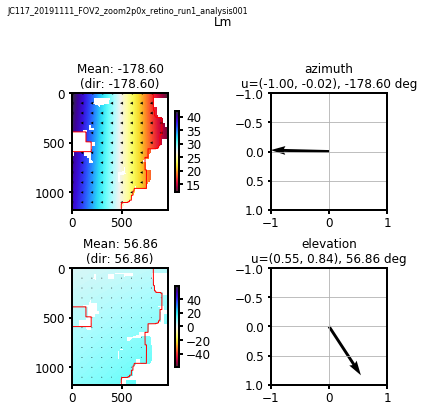

In [83]:
contour_lc='r'
contour_lw=1
spacing =100
scale = 0.001 #0.0001
width = 0.01 #1 #0.01
headwidth=5

for vi, (curr_visual_area, area_results) in enumerate(segmented_areas.items()):
    print(vi, curr_visual_area)
    if putils.isnumber(curr_visual_area):
        continue
    curr_segmented_mask = area_results['mask']
    grad_az, grad_el = calculate_gradients(curr_segmented_mask, img_az, img_el)
    
    # Plot results ------------
    curr_labeled_image = np.zeros(labeled_image.shape)
    curr_labeled_image[labeled_image==area_results['id']] = 1
    fig = plot_gradients_in_area(curr_labeled_image, img_az, img_el, grad_az, grad_el, cmap_phase=cmap_phase,
                                 contour_lc=contour_lc, contour_lw=contour_lw, spacing=spacing, 
                                 scale=scale, width=width, headwidth=headwidth)
    pl.subplots_adjust(wspace=0.5, hspace=0.5, top=0.8)
    putils.label_figure(fig, data_id)
    fig.suptitle(curr_visual_area)

    figname = 'gradients_%s' % curr_visual_area
    pl.savefig(os.path.join(curr_dst_dir, '%s.png' % figname))
    print(curr_dst_dir, figname)


## Assign cells to visual area(s)

# Load data

In [84]:
#### Get roi masks 
traceid= 'traces001'
roi_id = None
if roi_id is None:
    roi_id = roi_utils.get_roiid_from_traceid(animalid, session, fov, traceid=traceid)
r_masks, zprog_img = roi_utils.load_roi_masks(animalid, session, fov, rois=roi_id)
print("Loaded rois: %s" % roi_id)
d1, d2, nrois = r_masks.shape

##### Reshape and transform to match 'natural view'
pixel_size = putils.get_pixel_size() #* ds_factor
roi_masks_tr = np.dstack([coreg.transform_2p_fov(r_masks[:, :, i].astype(float), pixel_size) \
               for i in np.arange(0, nrois)]) # transform/orient
roi_masks = roi_masks_tr.astype(bool).astype(int)
print(roi_masks.shape)

Loaded rois: rois002
(1177, 972, 191)


## Load segmentation results

In [85]:
seg_results, seg_params = load_segmentation_results(animalid, session, fov, retinorun=retinorun)
seg_areas = seg_results['areas']

## Assign roi IDs to visual area

Loading roi assignments
Assigning rois to visual areas...
('Roi masks:', 1177, 972, 191)
('Lm', 187)
plotting assigned rois


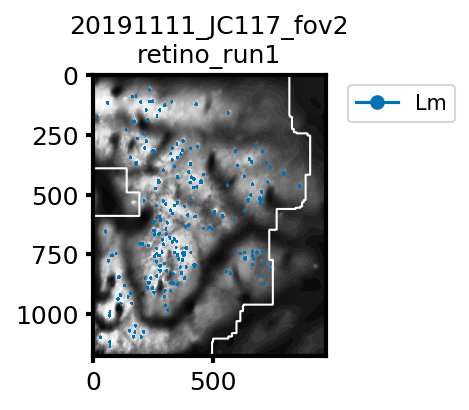

In [86]:
id_cmap='colorblind'
contour_lw=1
contour_lc='w'

#return_labeled_masks=False
verbose=False
create_new = False


if not create_new:
    try:
        print("Loading roi assignments")
        roi_assignments = load_roi_assignments(animalid, session, fov, retinorun=retinorun)
    except AssertionError:
        create_new=True

plot_rois = True

if create_new:
    print("Assigning rois to visual areas...")
    # Assign each ROI to visual areas
    roi_assignments = label_roi_masks(seg_results, roi_masks)

    # Save assignments
    assignments_fpath = os.path.join(curr_dst_dir, 'roi_assignments.json')
    with open(assignments_fpath, 'w') as f:
        json.dump(roi_assignments, f, indent=4)
    create_new=False

if plot_rois:
    print("plotting assigned rois")
    labeled_image = seg_results['labeled_image']
    f, ax = pl.subplots(figsize=(2,3), dpi=dpi)
    plot_labeled_rois(labeled_image, roi_assignments, roi_masks, cmap=id_cmap, surface=surface_2p, ax=ax,
                     contour_lw=contour_lw, contour_lc=contour_lc)
    
    putils.label_figure(fig, data_id)
    ax.set_title('%s\n%s' % (datakey, retinorun))
    pl.savefig(os.path.join(curr_dst_dir, 'assigned_rois.svg'))
